In [1]:
import numpy as np
import pandas as pd
import gc
from tqdm import *
import os
import copy
import sys
import time
from collections import Counter, deque
from multiprocessing import Pool, cpu_count

import transforms3d

from sklearn.manifold import TSNE, LocallyLinearEmbedding
from sklearn.cluster import MeanShift

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
# import ipyvolume as ipv
import open3d as o3d

import warnings
warnings.filterwarnings("ignore")

# %matplotlib inline
%matplotlib notebook

In [2]:
# ATM_PATH = "/Users/saby/Projects/atm/"
ATM_PATH = "/home/sabyasachi/Projects/ati/"
DATA_PATH = os.path.join(ATM_PATH, "data", "data", "datasets")

IISC_DATA_PATH = os.path.join(DATA_PATH, "IISC")
EXP_PATH = os.path.join(IISC_DATA_PATH, "2019-06-12","10-00-14-P1-6-auto-ccw_5loops_0.6_no_numba")

LIDAR_PCD_PATH = os.path.join(EXP_PATH, "complete_extracted")
LIDAR_CSV_PATH = os.path.join(IISC_DATA_PATH, "lidar.csv")

MAP_FILE = 'map_default_r.pcd'
POSE_FILE = 'pose_default_r.json'

In [3]:
FIRST_PCD = 2
FINAL_PCD = 879

VOXEL_SZ = 0.2
MAKE_2D = False
APPLY_CLUSTER = False

plt.rcParams['figure.figsize'] = [7, 7]

In [4]:
def draw_registration_result(src, dst, transformation):
    src_pcd = str(src) + ".pcd"
    dst_pcd = str(dst) + ".pcd"
    source, target = read_pcd(src_pcd=os.path.join(LIDAR_PCD_PATH, src_pcd),
                              dst_pcd=os.path.join(LIDAR_PCD_PATH, dst_pcd))
    
    source.paint_uniform_color([1, 0, 0]) # red
    target.paint_uniform_color([0, 0, 1]) # blue
    source.transform(transformation)
#     o3d.visualization.draw_geometries([source_temp, target_temp], width=1280, height=800)
    visualizer = JVisualizer()
    visualizer.add_geometry(source)
    visualizer.add_geometry(target)
    visualizer.show()
    
def preprocess_point_cloud(pcd, voxel_size):
    pcd_down = o3d.geometry.voxel_down_sample(pcd, voxel_size)
    radius_normal = voxel_size * 2
    o3d.geometry.estimate_normals(
        pcd_down,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_normal, max_nn=30))
    radius_feature = voxel_size * 5
    pcd_fpfh = o3d.registration.compute_fpfh_feature(
        pcd_down,
        o3d.geometry.KDTreeSearchParamHybrid(radius=radius_feature, max_nn=100))
    return pcd_down, pcd_fpfh

def read_pcd(src_pcd, dst_pcd):
    source = o3d.io.read_point_cloud(src_pcd)
    target = o3d.io.read_point_cloud(dst_pcd)
    return source, target

def prepare_dataset(source, target, voxel_size):
    source_down, source_fpfh = preprocess_point_cloud(source, voxel_size)
    target_down, target_fpfh = preprocess_point_cloud(target, voxel_size)
    return source_down, target_down, source_fpfh, target_fpfh


def execute_global_registration(source_down, target_down, source_fpfh,
                                target_fpfh, voxel_size):
    distance_threshold = voxel_size * 1.5
    result = o3d.registration.registration_ransac_based_on_feature_matching(
        source_down, target_down, source_fpfh, target_fpfh, distance_threshold,
        o3d.registration.TransformationEstimationPointToPoint(False), 4, [
            o3d.registration.CorrespondenceCheckerBasedOnEdgeLength(0.9),
            o3d.registration.CorrespondenceCheckerBasedOnDistance(
                distance_threshold)
        ], o3d.registration.RANSACConvergenceCriteria(4000000, 500))
    return result

def refine_registration(source, target, voxel_size, trans_init):
    distance_threshold = voxel_size * 0.4
#     result = o3d.registration.registration_icp(
#                 source, target, distance_threshold, trans_init,
#                 o3d.registration.TransformationEstimationPointToPoint())
    result = o3d.registration.registration_icp(
                source, target, distance_threshold, trans_init,
                o3d.registration.TransformationEstimationPointToPlane())
    return result

In [5]:
def make_2d(pcd):
    new_pcd = copy.deepcopy(pcd)
    new_pts = np.concatenate([np.asarray(pcd.points)[:,:-1],np.zeros((len(pcd.points),1))], axis=1)
    new_pcd.points = o3d.utility.Vector3dVector(new_pts)
    return new_pcd

# def read_pcd(pcd_id):
#     pcd_file = str(pcd_id) + ".pcd"
#     pcd = o3d.io.read_point_cloud(os.path.join(LIDAR_PCD_PATH, pcd_file))
#     return pcd

def draw_pcd(pcd, where='mat_3d'):
    if where is 'opn_nb':
        visualizer = o3d.JVisualizer()
        visualizer.add_geometry(pcd)
        visualizer.show()
    elif where is 'opn_view':
        o3d.visualization.draw_geometries([pcd], width=1280, height=800)
    elif where is 'mat_3d':
        pts = np.asarray(pcd.points)
        plt.scatter(pts[:,0], pts[:,1], pts[:,2])
        plt.show()
    elif where is 'mat_2d':
        pts = np.asarray(pcd.points)
        plt.scatter(pts[:,0], pts[:,1])
        plt.show()

def filter_pcd(old_pcd,
               apply_downsample = True,
               downsample_voxel_size = VOXEL_SZ,
               
               apply_outlier_removal = True,
               downsample_radius = 1,
               downsample_neighbors = 20,
               
               apply_crop = True,
               crop_min_arr = np.array([-100,-100,0]),
               crop_max_arr = np.array([100,100,100]),
               
               apply_cluster = False,
               cluster_neighbours = 30,
               cluster_labels = 2):
    np.random.seed(0)
    pcd = copy.deepcopy(old_pcd)
    
    if apply_downsample:
        voxel_down_pcd = o3d.geometry.voxel_down_sample(pcd, voxel_size = downsample_voxel_size)
        pcd = voxel_down_pcd

    if apply_outlier_removal:
        denser_pcd, ind = o3d.geometry.radius_outlier_removal(pcd,
                                                              nb_points = downsample_neighbors,
                                                              radius    = downsample_radius)
        pcd = denser_pcd
    
    if apply_crop:
        cropped_pcd = o3d.geometry.crop_point_cloud(pcd, crop_min_arr, crop_max_arr)
        pcd = cropped_pcd

    if apply_cluster:
        few_pts = np.asarray(pcd.points)
        try:
            few_pts_reduced = LocallyLinearEmbedding(n_neighbors=cluster_neighbours, n_components=2).fit_transform(few_pts)
        except Exception as e:
            try:
                few_pts_reduced = LocallyLinearEmbedding(n_neighbors=cluster_neighbours, n_components=2, eigen_solver='dense').fit_transform(few_pts)
            except Exception as e:
                few_pts_reduced = few_pts
        clf = MeanShift().fit(few_pts_reduced)
        pcd.points = o3d.utility.Vector3dVector(few_pts[clf.labels_ < cluster_labels])
    
    return pcd

def get_pose(src, dst):
    src_pcd = str(src) + ".pcd"
    dst_pcd = str(dst) + ".pcd"
#     src_pcd = str(src) + ".ply"
#     dst_pcd = str(dst) + ".ply"
    source, target = read_pcd(src_pcd=os.path.join(LIDAR_PCD_PATH, src_pcd),
                              dst_pcd=os.path.join(LIDAR_PCD_PATH, dst_pcd))
    
    source = filter_pcd(source)
    source = make_2d(source)
    
    target = filter_pcd(target)
    target = make_2d(target)

    voxel_size = VOXEL_SZ
    source_down, target_down, source_fpfh, target_fpfh = prepare_dataset(source, target, voxel_size)

    result_ransac = execute_global_registration(source_down, target_down,
                                                source_fpfh, target_fpfh,
                                                voxel_size)

    result_icp = refine_registration(source, target, voxel_size, result_ransac.transformation)
    return result_icp.transformation


def visualize_transform(pose):
    rot_mat = transforms3d.euler.euler2mat(pose['rot'][0],
                                             pose['rot'][1],
                                             pose['rot'][2],
                                             axes='sxyz')
    trans_vec = np.array(pose['trans'])
    scale_vec = np.ones(3)
    transform_mat = transforms3d.affines.compose(trans_vec, rot_mat, scale_vec)
    draw_registration_result(src=pose['src'],
                             dst=pose['dst'],
                             transformation=transform_mat)

In [6]:
def parallel_thread(file_idx):
    transform_mat = get_pose(src=file_idx + 1, dst=file_idx)
    pose = {"transform_mat":transform_mat,
            "src":file_idx+1,
            "dst":file_idx}
    return pose

In [7]:
from multiprocessing import Pool, cpu_count

In [8]:
file_indices = [idx for idx in tqdm_notebook(range(FIRST_PCD, FINAL_PCD)) if idx > 0]

In [9]:
process_pool = Pool(cpu_count()-1)

In [10]:
pose_list = [each for each in \
            tqdm_notebook(process_pool.imap( parallel_thread, file_indices), total=len(file_indices))]

In [11]:
df = pd.DataFrame(pose_list)

In [12]:
df.head()

,dst,src,transform_mat
0,2,3,"[[0.9999994885369147, -0.0010113979975114595, ..."
1,3,4,"[[0.9999990042800886, 0.0014111834861544326, 0..."
2,4,5,"[[0.9999860694168708, 0.005278349381883929, 0...."
3,5,6,"[[0.9999896982554006, -0.004539094961790835, 0..."
4,6,7,"[[0.9999994226969607, 0.0010745258234711313, 0..."


In [13]:
pt_list = [np.array([[0,0,0]]).T]

# for idx, pose in tqdm_notebook(enumerate(pose_list)):
for idx, row in tqdm_notebook(df.iterrows()):
    sample_mat = row['transform_mat']
    trans_vec, rot_mat, scale_mat, shear_mat = transforms3d.affines.decompose44(sample_mat)
    old_pt = pt_list[idx]
    new_pt = old_pt + np.array([trans_vec]).T
#     new_pt = np.matmul(sample_mat, old_pt)
    pt_list.append(new_pt)

In [14]:
X = [vec[0] for vec in pt_list]
Y = [vec[1] for vec in pt_list]
Z = [vec[2] for vec in pt_list]

In [15]:
%matplotlib notebook

<IPython.core.display.Javascript object>


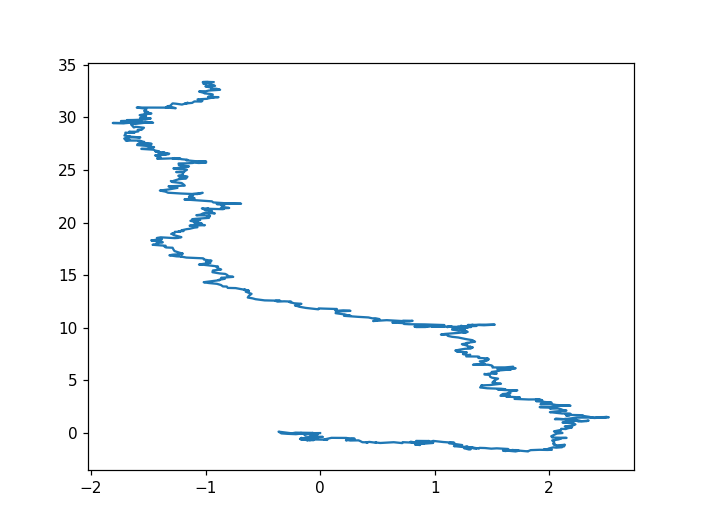

<IPython.core.display.Javascript object>


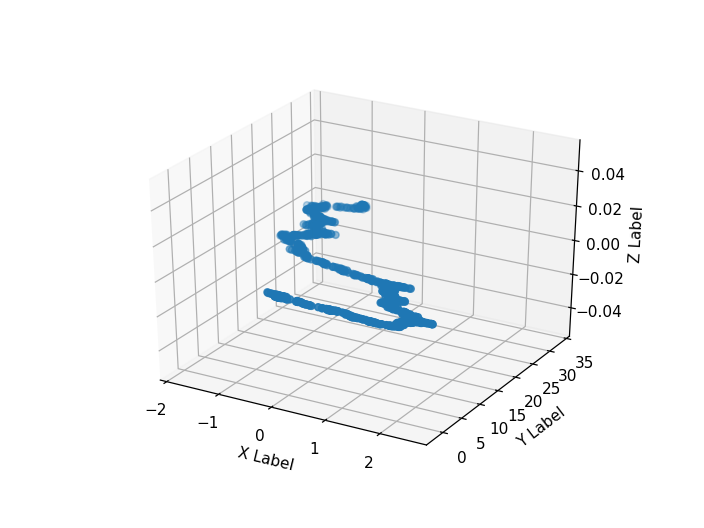

In [16]:
strt_idx = 0
last_idx = -1

plt.figure()
plt.plot(X[strt_idx:last_idx],
            Y[strt_idx:last_idx])
plt.show()

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X[strt_idx:last_idx],
           Y[strt_idx:last_idx],
           Z[strt_idx:last_idx])
#            c='r', marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()